# Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

In [1]:
%%capture
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip 'Flickr8k_Dataset.zip'
!rm -r 'Flickr8k_Dataset.zip'

!wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
!unzip 'caption_datasets.zip'
!rm -r 'caption_datasets.zip'

In [2]:
!rm dataset_flickr30k.json
!rm dataset_coco.json
!rm -r sample_data

## Imports

In [3]:
%matplotlib inline
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage.transform
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing and Loading


In [4]:
# sets device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
id2word = {}
def build_word_dict(captions, min_word_count):
    """
    Builds a word dictionary from caption tokens, filtering by minimum count.
    """
    word_count = Counter(token for caption in captions for token in caption)
    vocab = [word for word, count, in word_count.items() if count>= min_word_count]

    word_dict = {word: idx+4 for idx, word in enumerate(vocab)}
    word_dict['<start>'] = 0
    word_dict['<eos>'] = 1
    word_dict['<unk>'] = 2
    word_dict['<pad>'] = 3

    return word_dict

In [6]:
def tokenize_captions(captions, word_dict, max_length):
    """
    Converts list of tokenized captions to indexed and padded format.
    """
    indexed, caps_len = [], []
    for tokens in captions:
        idxs = [word_dict.get(token, word_dict['<unk>']) for token in tokens]
        padded = [word_dict['<start>']] + idxs + [word_dict['<eos>']]
        padded += [word_dict['<pad>']] * (max_length - len(tokens))
        indexed.append(padded)
        caps_len.append(len(tokens) + 2)
    return indexed, caps_len

In [7]:
def generate_json_data(split_path, data_path, min_word_count, max_caption_len=100):
    """
    Splits data into train, val, test dataset and saves as JSON
    """
    with open(split_path, 'r') as f:
        split_data = json.load(f)

    train_img_paths, val_img_paths, test_img_paths = [], [], []
    train_captions, val_captions, test_captions = [], [], []

    for img in split_data['images']:
        for sentence in img['sentences']:
            img_path = os.path.join(data_path, img['filename'])
            tokens = sentence['tokens']

            if img['split'] == 'train':
                train_img_paths.append(img_path)
                train_captions.append(tokens)
            elif img['split'] == 'val':
                val_img_paths.append(img_path)
                val_captions.append(tokens)
            elif img['split'] == 'test':
                test_img_paths.append(img_path)
                test_captions.append(tokens)

    word_dict = build_word_dict(train_captions + val_captions + test_captions, min_word_count)

    train_caption_ids, train_caption_lens = tokenize_captions(train_captions, word_dict, max_caption_len)
    val_caption_ids, val_caption_lens = tokenize_captions(val_captions, word_dict, max_caption_len)
    test_caption_ids, test_caption_lens = tokenize_captions(test_captions, word_dict, max_caption_len)

    # Output paths
    with open(os.path.join(data_path, 'word_dict.json'), 'w') as f:
        json.dump(word_dict, f)

    with open(os.path.join(data_path, 'train_img_paths.json'), 'w') as f:
        json.dump(train_img_paths, f)
    with open(os.path.join(data_path, 'val_img_paths.json'), 'w') as f:
        json.dump(val_img_paths, f)
    with open(os.path.join(data_path, 'test_img_paths.json'), 'w') as f:
        json.dump(test_img_paths, f)

    with open(os.path.join(data_path, 'train_captions.json'), 'w') as f:
        json.dump(train_caption_ids, f)
    with open(os.path.join(data_path, 'val_captions.json'), 'w') as f:
        json.dump(val_caption_ids, f)
    with open(os.path.join(data_path, 'test_captions.json'), 'w') as f:
        json.dump(test_caption_ids, f)

    with open(os.path.join(data_path, 'train_caption_lens.json'), 'w') as f:
        json.dump(train_caption_lens, f)
    with open(os.path.join(data_path, 'val_caption_lens.json'), 'w') as f:
        json.dump(val_caption_lens, f)
    with open(os.path.join(data_path, 'test_caption_lens.json'), 'w') as f:
        json.dump(test_caption_lens, f)

In [8]:
data_path = '/content/Flicker8k_Dataset'
min_word_freq = 5
split_path = 'dataset_flickr8k.json'

generate_json_data(split_path, data_path, min_word_freq)

In [9]:
class CaptionDataset(Dataset):
    def __init__(self, data_path, split, transform, num_captions=5):
        self.img_paths = json.load(open(os.path.join(data_path, f'{split}_img_paths.json'), 'r'))
        self.captions = json.load(open(os.path.join(data_path, f'{split}_captions.json'), 'r'))
        self.caption_lens = json.load(open(os.path.join(data_path, f'{split}_caption_lens.json'), 'r'))
        self.num_captions = num_captions
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.split == 'train':
            return torch.FloatTensor(img), torch.tensor(self.captions[idx]), torch.tensor(self.caption_lens[idx]).reshape(-1)

        all_captions = [self.captions[i] for i, path in enumerate(self.img_paths) if path == img_path]

        return torch.FloatTensor(img), torch.tensor(self.captions[idx]), torch.tensor(self.caption_lens[idx]).reshape(-1), torch.tensor(all_captions)

In [10]:
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32
data_path = '/content/Flicker8k_Dataset'

train_dataset = CaptionDataset(data_path, 'train', img_transform)
val_dataset = CaptionDataset(data_path, 'val', img_transform)
test_dataset = CaptionDataset(data_path, 'test', img_transform)

### Visualize data

In [11]:
with open(os.path.join(data_path, 'word_dict.json'), 'r') as f:
    word2id = json.load(f)

id2word = {v: k for k, v in word2id.items()}

def decode_caption(caption, word_dict=word2id):
    idx2word = {idx: word for word, idx in word2id.items()}
    decoded_caption = []

    for id in caption.numpy():
        if idx2word[id] not in ["<start>", "<eos>", "<unk>", "<pad>"]:
            decoded_caption.append(idx2word[id])

    return " ".join(decoded_caption)

a boy in a red shirt in front of a long blue wall raises his at the camera



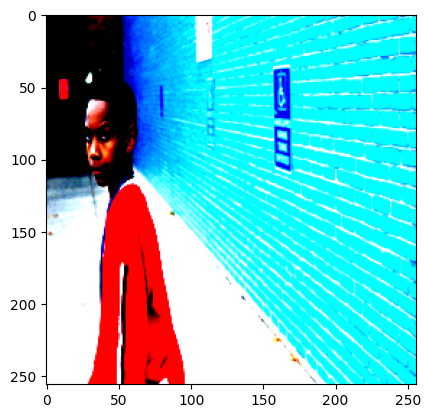

In [12]:
img, caption, _ = train_dataset[100]

print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0));

a black haired woman in a white skirt and black boots is carrying a red bag and walking down the street
a short girl in a white skirt black boots and a gray green jacket carrying a red bag on the sidewalk
a woman dressed up walks down the sidewalk with her back turned
a woman in a skirt and boots with a red bag walking down the sidewalk
a woman with a short white skirt black boots and a red bag walks away



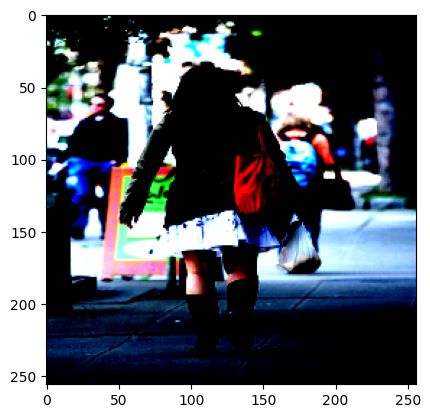

In [13]:
img, _, _, all_captions = val_dataset[120]

for caption in all_captions:
    print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0));

In [14]:
batch_size = 32
workers = 2

# dataloader for train and val set
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=workers)

# quick check to see if data is properly loaded or not
next_images, next_captions, next_caption_lens = next(iter(train_loader))
print(next_images.shape)
print(next_captions.shape)
print(next_caption_lens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])


## Model Architecture


In [15]:
from torchvision.models import vgg19

class VGGEncoder(nn.Module):
  def __init__(self, output_size=14):
    super(VGGEncoder, self).__init__()
    self.output_size = output_size

    vgg = vgg19(pretrained=True)
    self.model = nn.Sequential(*list(vgg.children())[:-1])

    self.pool = nn.AdaptiveAvgPool2d((output_size, output_size))
    self.fine_tune()

  def forward(self, x):
    out = self.model(x)
    out = self.pool(out)
    out = out.permute(0, 2, 3, 1)
    return out

  def fine_tune(self, fine_tune=True):
    for param in self.model.parameters():
      param.requires_grad = False

    if fine_tune:
      for child in list(self.model.children())[5:]:
        for param in child.parameters():
          param.requires_grad = fine_tune

In [16]:
from torchvision.models import resnet152
class ResNetEncoder(nn.Module):
  def __init__(self, output_size=14):
    super(ResNetEncoder, self).__init__()
    self.output_size = output_size

    resnet = resnet152(pretrained=True)
    self.model = nn.Sequential(*list(resnet.children())[:-2])

    self.pool = nn.AdaptiveAvgPool2d((output_size, output_size))
    self.fine_tune()

  def forward(self, x):
    out = self.model(x)
    out = self.pool(out)
    out = out.permute(0, 2, 3, 1)
    return out

  def fine_tune(self, fine_tune=True):
    for param in self.model.parameters():
      param.requires_grad = False

    if fine_tune:
      for child in list(self.model.children())[5:]:
        for param in child.parameters():
          param.requires_grad = fine_tune

In [17]:
from torchvision.models import densenet201
class ImageEncoder(nn.Module):
  def __init__(self, output_size=14):
    super(ImageEncoder, self).__init__()
    self.output_size = output_size

    densenet = densenet201(pretrained=True)
    self.model = nn.Sequential(*list(densenet.children())[:-1])

    self.pool = nn.AdaptiveAvgPool2d((output_size, output_size))
    self.fine_tune()

  def forward(self, x):
    out = self.model(x)
    out = self.pool(out)
    out = out.permute(0, 2, 3, 1)
    return out

  def fine_tune(self, fine_tune=True):
    for param in self.model.parameters():
      param.requires_grad = False

    if fine_tune:
      for child in list(self.model.children())[5:]:
        for param in child.parameters():
          param.requires_grad = fine_tune

In [18]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # (batch_size, num_pixels, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # (batch_size, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)  # (batch_size, num_pixels)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)  # (batch_size, num_pixels)

    def forward(self, encoder_out, decoder_hidden):
        annotation_vec = self.encoder_att(encoder_out)  # project each image region feature a_i into the attention space
        hidden_state = self.decoder_att(decoder_hidden)  # projects decoder's hidden state to the attention space
        eti = self.full_att(self.tanh(annotation_vec + hidden_state.unsqueeze(1))).squeeze(2)  # e_{ti}
        alpha = self.softmax(eti)  # softmax layer calculates attention weights
        context_vec = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # z_t the context vector

        return context_vec, alpha

In [19]:
class Decoder(nn.Module):
    """
    LSTM decoder with attention for image captioning.
    """
    def __init__(
        self,
        attention_dim: int,
        embed_dim: int,
        decoder_dim: int,
        vocab_size: int,
        encoder_dim: int = 2048,
        dropout: float = 0.5,
    ):
        super().__init__()
        # feature sizes
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # modules
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.decoder_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        # initialize LSTM from image features
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # gating for context vector
        self.beta_gate = nn.Linear(decoder_dim, encoder_dim)

        self.output_proj = nn.Linear(decoder_dim, vocab_size)

        self._init_weights()

    def _init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.output_proj.weight.data.uniform_(-0.1, 0.1)
        self.output_proj.bias.data.zero_()

    def init_hidden_states(self, encoder_feats: torch.Tensor):
        """
        Create initial hidden & cell states from the mean encoder features.
        :param encoder_feats: (batch, num_pixels, encoder_dim)
        """
        mean_feats = encoder_feats.mean(dim=1)
        return self.init_h(mean_feats), self.init_c(mean_feats)

    def forward(
        self,
        encoder_out: torch.Tensor,
        captions: torch.Tensor,
        caption_lengths: torch.Tensor,
    ):
        """
        :param encoder_out: (batch, enc_size, enc_size, encoder_dim)
        :param captions:    (batch, max_caption_len)
        :param caption_lengths: (batch, 1)
        :returns:
          - predictions:      (batch, max_steps, vocab_size)
          - sorted_captions:  (batch, max_caption_len)
          - decode_lengths:   List[int]
          - attention_weights:(batch, max_steps, num_pixels)
          - sort_idx:         (batch,)
        """
        batch_size = encoder_out.size(0)
        # (batch, num_pixels, encoder_dim)
        encoder_feats = encoder_out.view(batch_size, -1, self.encoder_dim)
        num_pixels = encoder_feats.size(1)

        # descending caption length
        lengths, sort_idx = caption_lengths.squeeze(1).sort(descending=True)
        encoder_feats = encoder_feats[sort_idx]
        sorted_caps = captions[sort_idx]
        decode_lengths = (lengths - 1).tolist()
        max_steps = max(decode_lengths)

        embed = self.embedding(sorted_caps)  # (batch, max_len, embed_dim)

        # init LSTM state
        hidden_state, cell_state = self.init_hidden_states(encoder_feats)

        device = encoder_feats.device
        preds = encoder_feats.new_zeros(batch_size, max_steps, self.vocab_size)
        alphas = encoder_feats.new_zeros(batch_size, max_steps, num_pixels)

        for t in range(max_steps):
            active_mask = torch.tensor([l > t for l in decode_lengths], device=device)
            if not active_mask.any():
                break
            idx = active_mask.nonzero(as_tuple=False).squeeze(1)

            # attend
            ctx, alpha = self.attention(encoder_feats[idx], hidden_state[idx])

            # gate the context
            gate = torch.sigmoid(self.beta_gate(hidden_state[idx]))
            ctx = gate * ctx

            # LSTMCell
            lstm_input = torch.cat([embed[idx, t, :], ctx], dim=1)
            h_t, c_t = self.decoder_cell(lstm_input, (hidden_state[idx], cell_state[idx]))
            hidden_state[idx], cell_state[idx] = h_t, c_t

            # project to vocab
            step_preds = self.output_proj(self.dropout(h_t))
            preds[idx, t, :] = step_preds
            alphas[idx, t, :] = alpha.to(alphas.dtype)

        return preds, sorted_caps, decode_lengths, alphas, sort_idx

## Utility functions


In [20]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [21]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [22]:
from pathlib import Path

def save_checkpoint(
    epoch: int,
    epochs_since_improvement: int,
    encoder: torch.nn.Module,
    decoder: torch.nn.Module,
    encoder_optimizer: torch.optim.Optimizer | None,
    decoder_optimizer: torch.optim.Optimizer,
    bleu4: float,
    is_best: bool,
    ckpt_dir: str = "checkpoints",
    prefix: str = "image_captioning"
):
    """
    Save model + optimizer state_dicts.

    Args:
        epoch: current epoch (1-indexed).
        epochs_since_improvement: epochs since last BLEU-4 improvement.
        encoder: the encoder network.
        decoder: the decoder network.
        encoder_optimizer: optimizer for encoder (or None).
        decoder_optimizer: optimizer for decoder.
        bleu4: current BLEU-4 score.
        is_best: True if this is the best model so far.
        ckpt_dir: directory to save checkpoints into.
        prefix: filename prefix (no extension).
    """
    ckpt_path = Path(ckpt_dir)
    ckpt_path.mkdir(exist_ok=True)

    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "bleu-4": bleu4,
        "encoder_state_dict": encoder.state_dict(),
        "decoder_state_dict": decoder.state_dict(),
        "decoder_optimizer_state_dict": decoder_optimizer.state_dict(),
    }
    # Only include encoder optimizer if it exists
    if encoder_optimizer is not None:
        state["encoder_optimizer_state_dict"] = encoder_optimizer.state_dict()

    # Filename with zero-padded epoch number
    fname = f"{prefix}_epoch{epoch:02d}.pth"
    full_path = ckpt_path / fname
    torch.save(state, full_path)
    print(f"Checkpoint saved: {full_path}")

    # If this is the best model so far, overwrite the "best" symlink
    if is_best:
        best_path = ckpt_path / f"{prefix}_best.pth"
        torch.save(state, best_path)
        print(f"*** New best model saved: {best_path} ***")

## Training


In [23]:
from torch.cuda.amp import autocast, GradScaler
torch.backends.cudnn.benchmark = True  # Optimize conv ops

scaler = GradScaler()

def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    losses = []
    top5accs = []

    decoder.train()
    encoder.train()

    scaler = GradScaler()

    for i, (imgs, caps, cap_lens) in enumerate(tqdm(train_loader, total=len(train_loader))):
        imgs = imgs.to(device, non_blocking=True)
        caps = caps.to(device, non_blocking=True)
        cap_lens = cap_lens.to(device, non_blocking=True)

        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()

        with autocast():
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)
            targets = caps_sorted[:, 1:]

            scores_packed = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            loss = criterion(scores_packed, targets_packed) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        scaler.scale(loss).backward()

        if grad_clip is not None:
            scaler.unscale_(decoder_optimizer)
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                scaler.unscale_(encoder_optimizer)
                clip_gradient(encoder_optimizer, grad_clip)

        scaler.step(decoder_optimizer)
        if encoder_optimizer is not None:
            scaler.step(encoder_optimizer)

        scaler.update()

        top5 = accuracy(scores_packed, targets_packed, 5)
        losses.append(loss.item())
        top5accs.append(top5)

    return np.mean(losses), np.mean(top5accs)

In [25]:
# Run this cell to download WordNet
import nltk
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')

def compute_meteor_scores(references_ids, hypotheses_ids):
    meteor_scores = []
    # printed = False
    for refs, hyp in zip(references_ids, hypotheses_ids):
        # Convert refs and hyp to strings
        refs_str = [[id2word[tok] for tok in ref] for ref in refs]
        hyp_str = [id2word[tok] for tok in hyp]

        score = meteor_score(refs_str, hyp_str)
        meteor_scores.append(score)

    return sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0.0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
def val_epoch(val_loader, encoder, decoder, criterion):
    losses = []
    top5accs = []

    decoder.eval()
    if encoder is not None:
        encoder.eval()

    references = []
    hypotheses = []

    with torch.no_grad():
        for i, (imgs, caps, cap_lens, all_caps) in enumerate(tqdm(val_loader, total=len(val_loader))):
            imgs = imgs.to(device, non_blocking=True)
            caps = caps.to(device, non_blocking=True)
            cap_lens = cap_lens.to(device, non_blocking=True)

            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)
            targets = caps_sorted[:, 1:]

            scores_copy = scores.clone()

            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            top5 = accuracy(scores, targets, 5)

            losses.append(loss.item())
            top5accs.append(top5)

            sort_ind = sort_ind.cpu()
            all_caps = all_caps[sort_ind]
            for j in range(all_caps.shape[0]):
                img_caps = all_caps[j].tolist()
                img_captions = list(map(
                    lambda caption: [word for word in caption if word not in {word2id['<start>'], word2id['<pad>']}],
                    img_caps))
                references.append(img_captions)

            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = [preds[j][:decode_lengths[j]] for j in range(len(preds))]
            hypotheses.extend(temp_preds)

        assert len(references) == len(hypotheses)
        bleu_scores = [corpus_bleu(references, hypotheses),
                       corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0)),
                       corpus_bleu(references, hypotheses, weights=(0.25, 0.5, 0, 0)),
                       corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))]
        m_score = compute_meteor_scores(references, hypotheses)

    return np.mean(losses), np.mean(top5accs), bleu_scores, m_score

In [27]:
train_config = {
    'embed_dim': 512,     # dim of word embedding
    'attention_dim': 512, # dim of attention linear layers
    'decoder_dim': 512,   # dim of decoder RNN
    'encoder_dim': 1920,
    'encoder_lr': 1e-4,   # lr for encoder if fine-tuning
    'decoder_lr': 4e-4,   # lr for decoder
    'grad_clip': 5.,      # clip gradients at an absolute value
    'alpha_c': 1.,        # regularization parameter for 'doubly stochastic attention'
    'num_epochs': 20,
    'fine_tune_encoder': False,
    'lr_decay_factor': 0.8,
    'lr_decay_patience': 8,
}

In [ ]:
# model parameters
embed_dim = 512      # dim of word embeddings
attention_dim = 512  # dim of attention linear layers
decoder_dim = 512    # dim of decoder RNN
encoder_dim = 1920   # 512 for VGG, 2048 for ResNet, 1920 for DenseNet, 1024 for GoogLeNet, 3 for AlexNet
encoder_lr = 1e-4    # learning rate for encoder if fine-tuning
decoder_lr = 4e-4    # learning rate for decoder
grad_clip = 5.       # clip gradients at an absolute value of
alpha_c = 1.         # regularization parameter for 'doubly stochastic attention'
vocab_size = len(word2id)

lr_decay_factor = 0.8
lr_decay_patience = 8

num_epochs = 20
epochs_since_improvement = 0

fine_tune_encoder = False  # fine-tune encoder?
cudnn.benchmark = True     # set to true only if inputs to model are fixed size

# model setup
decoder = Decoder(attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim)
decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

encoder = ImageEncoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

encoder = encoder.to(device)
decoder = decoder.to(device)

# lr scheduler
encoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)

# criterion for loss
criterion = nn.CrossEntropyLoss().to(device)

# loop
best_bleus = np.zeros(4)
best_avg = 0.
best_meteor = 0.
for epoch in range(1, num_epochs + 1):
    loss_train, acc_train = train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
    loss_val, acc_val, bleu_vals, m_score = val_epoch(val_loader, encoder, decoder, criterion)

    # reduce the learning rate on plateau
    decoder_lr_scheduler.step(bleu_vals[3])
    if fine_tune_encoder:
        encoder_lr_scheduler.step(bleu_vals[3])

    # check if there was an improvement
    score_avg = (np.sum(bleu_vals) + m_score) / 5
    is_best = score_avg > best_avg
    best_bleus = np.maximum(bleu_vals, best_bleus)
    best_meteor = max(m_score, best_meteor)
    best_avg = max(score_avg, best_avg)
    if not is_best:
        epochs_since_improvement += 1
    else:
        epochs_since_improvement = 0

    print('-' * 40)
    print(f'epoch: {epoch}, train loss: {loss_train:.4f}, train acc: {acc_train:.2f}%, valid loss: {loss_val:.4f}, valid acc: {acc_val:.2f}%, best BLEU-1: {best_bleus[3]:.4f}, best BLEU-2: {best_bleus[2]:.4f}, best BLEU-3: {best_bleus[1]:.4f}, best BLEU-4: {best_bleus[0]:.4f}, best METEOR: {best_meteor:.4f}')
    print('-' * 40)
    # save the checkpoint
    save_checkpoint(
        epoch=epoch,
        epochs_since_improvement=epochs_since_improvement,
        encoder=encoder,
        decoder=decoder,
        encoder_optimizer=encoder_optimizer if fine_tune_encoder else None,
        decoder_optimizer=decoder_optimizer,
        bleu4=bleu_vals[0],    # BLEU-4 is the first element
        is_best=is_best
    )

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 198MB/s]


  0%|          | 0/938 [00:00<?, ?it/s]

## Inference


In [ ]:
def _load_and_preprocess(image_path: str, image_size: int = 256):
    """Load image from disk, resize, normalize and return a tensor."""
    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (image_size, image_size))
    assert img.shape == (image_size, image_size, 3)
    assert np.max(img) <= 255

    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return tf(img)  # (3, H, W)

In [ ]:
def _plot_attention(image_path: str, caption: list, alphas: np.ndarray, grid_size: int, upsample: int = 24):
    """Display attention maps over the image for each word in caption."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize([grid_size * upsample]*2, Image.LANCZOS)

    num_words = len(caption)
    cols = 5
    rows = int(np.ceil(num_words / cols))
    plt.figure(figsize=(cols*4, rows*3))

    for t, word in enumerate(caption):
        plt.subplot(rows, cols, t+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(word, fontsize=12)

        alpha_map = alphas[t]
        alpha_up = skimage.transform.pyramid_expand(
            alpha_map, upscale=upsample, sigma=8
        )
        plt.imshow(alpha_up, alpha=0.8, cmap='gray')
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms

def generate_caption(
    encoder,
    decoder,
    image_path: str,
    word_map: dict,
    beam_size: int = 5,
    max_caption_len: int = 50,
    return_attention: bool = False,
    device: str = "cpu"
):
    """
    Generate a caption for an image using beam search.
    """

    if '<end>' in word_map:
        end_idx = word_map['<end>']
    elif '<eos>' in word_map:
        end_idx = word_map['<eos>']
    elif 'endseq' in word_map:
        end_idx = word_map['endseq']
    else:
        raise KeyError(
            "No end-of-sentence token found in word_map. "
            "Make sure one of '<end>', '<eos>', or 'endseq' is present."
        )

    # Load & preprocess image
    img = Image.open(image_path).convert("RGB")
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        normalize
    ])
    image = transform(img).unsqueeze(0).to(device) # (1,3,256,256)

    # Encode
    encoder_out = encoder(image) # (1, H, W, C)
    encoder_out = encoder_out.permute(0, 3, 1, 2) # (1, C, H, W)
    enc_dim     = encoder_out.size(1)
    encoder_out = encoder_out.reshape(1, enc_dim, -1).permute(0,2,1) # (1, num_pixels, enc_dim)
    num_pixels  = encoder_out.size(1)

    # Beam search
    encoder_out = encoder_out.expand(beam_size, num_pixels, enc_dim)
    k = beam_size
    vocab_size = len(word_map)
    seqs = [[word_map['<start>']]] * k
    top_k_scores = torch.zeros(k, 1).to(device)
    seqs_alpha = torch.ones(k, 1, num_pixels).to(device)

    complete_seqs = []
    complete_seqs_alpha  = []
    complete_seqs_scores = []

    # hidden & cell from decoder’s init method
    h, c = decoder.init_hidden_states(encoder_out)

    step = 1
    while True:
        # last words
        prev_words = torch.LongTensor([seq[-1] for seq in seqs]).to(device)
        embeddings = decoder.embedding(prev_words)

        # attention
        context, alpha = decoder.attention(encoder_out, h)
        gate = torch.sigmoid(decoder.beta_gate(h))
        context = gate * context

        # decode one step
        h, c = decoder.decoder_cell(
            torch.cat([embeddings, context], dim=1), (h, c)
        )
        scores = decoder.output_proj(h)
        scores = F.log_softmax(scores, dim=1)

        scores = top_k_scores.expand_as(scores) + scores

        if step == 1:
            scores = scores[0]

        # flatten & top-k
        scores, indices = scores.view(-1).topk(
            k, dim=0, largest=True, sorted=True
        )
        prev_beams = indices // vocab_size
        next_words = indices %  vocab_size

        # build new beams
        new_seqs = []
        new_seqs_alpha = []
        for b, w in zip(prev_beams, next_words):
            new_seqs.append(seqs[b] + [w.item()])
            new_seqs_alpha.append(
                torch.cat([seqs_alpha[b], alpha[b].unsqueeze(0)], dim=0)
            )

        seqs = []
        seqs_alpha = []
        for i, seq in enumerate(new_seqs):
            if seq[-1] == end_idx:
                complete_seqs.append(seq)
                complete_seqs_alpha.append(new_seqs_alpha[i])
                complete_seqs_scores.append(scores[i])
            else:
                seqs.append(seq)
                seqs_alpha.append(new_seqs_alpha[i])

        k = len(seqs)
        if k == 0 or step >= max_caption_len:
            break

        h = h[prev_beams[:k]]
        c = c[prev_beams[:k]]
        encoder_out = encoder_out[prev_beams[:k]]
        top_k_scores = scores[:k].unsqueeze(1)
        step += 1

    if not complete_seqs_scores:
        complete_seqs = seqs
        complete_seqs_alpha = seqs_alpha
        complete_seqs_scores = [s.item() for s in top_k_scores.squeeze(1)]

    best_idx = complete_seqs_scores.index(max(complete_seqs_scores))
    best_seq = complete_seqs[best_idx]
    alphas = complete_seqs_alpha[best_idx].cpu().detach().numpy()

    idx2word = {v: k for k, v in word_map.items()}
    caption  = []
    for idx in best_seq:
        w = idx2word[idx]
        if w == '<start>': continue
        if idx == end_idx:   break
        caption.append(w)

    return (caption, alphas) if return_attention else caption

Loaded checkpoint from epoch 6, BLEU-4=0.1585


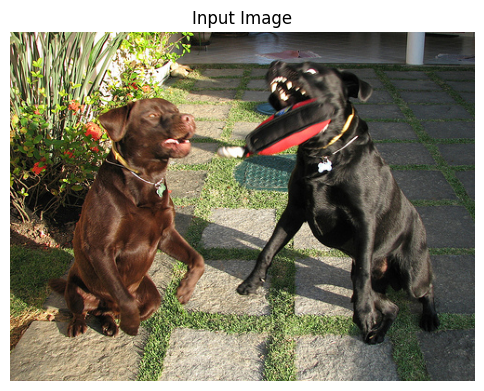

Predicted caption:
a black dog is playing with a red toy in its mouth


In [ ]:
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-params (must match training)
embed_dim     = 512
attention_dim = 512
decoder_dim   = 512
encoder_dim   = 1920
vocab_size    = len(word2id)

# Instantiate models
encoder = ImageEncoder(output_size=14).to(device)
decoder = Decoder(
    attention_dim=attention_dim,
    embed_dim=embed_dim,
    decoder_dim=decoder_dim,
    vocab_size=vocab_size,
    encoder_dim=encoder_dim,
).to(device)

# Load checkpoint
ckpt_path = Path("/content/checkpoints/image_captioning_best.pth")
ckpt = torch.load(ckpt_path, map_location=device)
encoder.load_state_dict(ckpt["encoder_state_dict"])
decoder.load_state_dict(ckpt["decoder_state_dict"])
print(f"Loaded checkpoint from epoch {ckpt['epoch']}, BLEU-4={ckpt['bleu-4']:.4f}")

encoder.eval()
decoder.eval()

# Choose image and beam size
image_path = "/content/Flicker8k_Dataset/1030985833_b0902ea560.jpg"
beam_size  = 5

# Display Image
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Run inference and plot attention
caption, alphas = generate_caption(
    encoder=encoder,
    decoder=decoder,
    image_path=image_path,
    word_map=word2id,
    beam_size=beam_size,
    return_attention=True,
    device=device,
)

# Print out the final caption
print("Predicted caption:")
print(" ".join(caption))